Model Accuracy: 0.80

Confusion Matrix:
[[TN FP]
 [FN TP]]
[[100  14]
 [ 22  43]]

Precision: 0.75
Recall: 0.66
F1 Score: 0.70


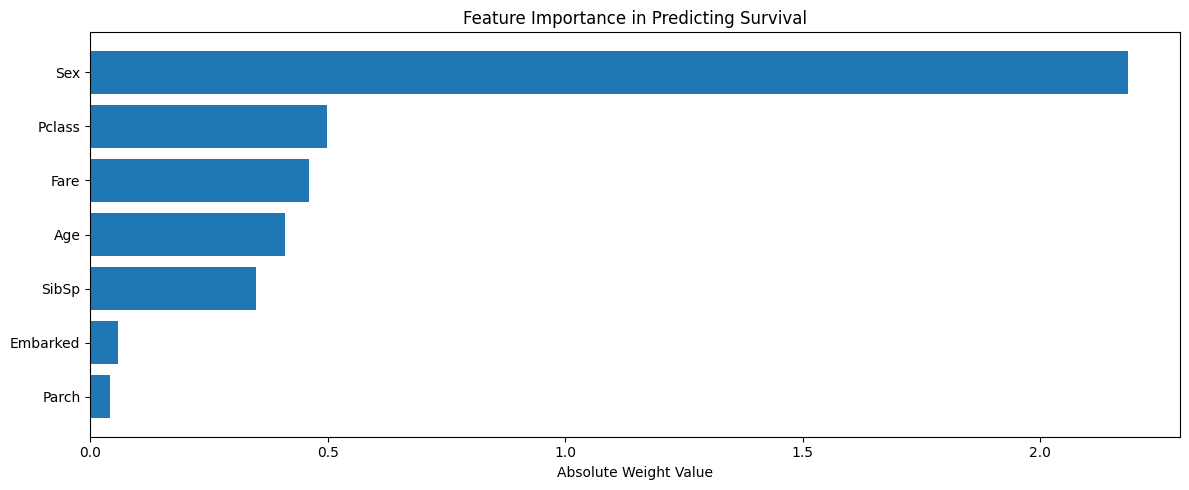

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the dataset
df = pd.read_csv(r"C:\Users\vargh\Downloads\titanic.csv")

# Data preprocessing function
def preprocess_data(df):
    # Create a copy of the dataframe
    data = df.copy()
    
    # Handle missing values without chained assignment
    data = data.assign(
        Age=data['Age'].fillna(data['Age'].median()),
        Embarked=data['Embarked'].fillna(data['Embarked'].mode()[0])
    )
    
    # Drop unnecessary columns
    columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    data = data.drop(columns=columns_to_drop)
    
    # Convert categorical variables to numerical
    data = data.assign(Sex=(data['Sex'] == 'male').astype(int))
    data = data.assign(Embarked=pd.Categorical(data['Embarked']).codes)
    
    # Feature scaling using assign
    for column in ['Age', 'Fare']:
        mean_val = data[column].mean()
        std_val = data[column].std()
        data = data.assign(**{column: (data[column] - mean_val) / std_val})
    
    return data

# Rest of the code remains the same as in previous version
class LogisticRegression:
    def __init__(self, learning_rate=0.001, num_iterations=10000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
        
    def sigmoid(self, z):
        # Clip z to avoid overflow
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Initialize weights and bias
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Gradient descent
        for i in range(self.num_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)
            
            # Calculate gradients
            dw = (1/n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1/n_samples) * np.sum(y_predicted - y)
            
            # Add L2 regularization
            lambda_param = 0.01
            dw += (lambda_param / n_samples) * self.weights
            
            # Update parameters with momentum
            if i == 0:
                self.velocity_w = np.zeros_like(self.weights)
                self.velocity_b = 0
            
            momentum = 0.9
            self.velocity_w = momentum * self.velocity_w - self.learning_rate * dw
            self.velocity_b = momentum * self.velocity_b - self.learning_rate * db
            
            self.weights += self.velocity_w
            self.bias += self.velocity_b
    
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return (y_predicted > 0.5).astype(int)
    
    def get_feature_importance(self):
        return np.abs(self.weights)

# Calculate accuracy
def calculate_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Preprocess the data
processed_data = preprocess_data(df)

# Prepare features and target
X = processed_data.drop('Survived', axis=1).values
y = processed_data['Survived'].values

# Split the data into training and testing sets
np.random.seed(42)
indices = np.random.permutation(len(X))
train_size = int(0.8 * len(X))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Train the model
model = LogisticRegression(learning_rate=0.001, num_iterations=10000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate and print accuracy
accuracy = calculate_accuracy(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Create confusion matrix
def create_confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

confusion_mat = create_confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print("[[TN FP]")
print(" [FN TP]]")
print(confusion_mat)

# Calculate and print additional metrics
precision = confusion_mat[1,1] / (confusion_mat[1,1] + confusion_mat[0,1])
recall = confusion_mat[1,1] / (confusion_mat[1,1] + confusion_mat[1,0])
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

# Create visualizations
plt.figure(figsize=(12, 5))

# Plot: Feature Importance
feature_names = processed_data.drop('Survived', axis=1).columns
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model.get_feature_importance()
})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance in Predicting Survival')
plt.xlabel('Absolute Weight Value')
plt.tight_layout()
plt.show()